# Word2Vec

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

TensorFlow 2.x selected.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [0]:
text = ['i am yours', 'how are you', 'he says goodbye', 'i love you', 'i will kill you', 'it is time to die']

tokenizer = keras.preprocessing.text.Tokenizer(char_level=False) # toknizing을 할 수 있는 tokenizer을 불러온다
# char_level=True
tokenizer.fit_on_texts(text) # 위 텍스트 데이터를 tokenizing할 수있도록 tokenizer를 fitting해준다.
word2index = tokenizer.word_index

In [3]:
word2index

{'am': 3,
 'are': 6,
 'die': 17,
 'goodbye': 9,
 'he': 7,
 'how': 5,
 'i': 1,
 'is': 14,
 'it': 13,
 'kill': 12,
 'love': 10,
 'says': 8,
 'time': 15,
 'to': 16,
 'will': 11,
 'you': 2,
 'yours': 4}

In [4]:
tokenizer.texts_to_sequences(text)

[[1, 3, 4],
 [5, 6, 2],
 [7, 8, 9],
 [1, 10, 2],
 [1, 11, 12, 2],
 [13, 14, 15, 16, 17]]

In [0]:
indexed_corpus = tokenizer.texts_to_sequences(text)

embedding_dim = 100
vocab_size = len(word2index)

input_target = keras.layers.Input((1,))
input_context = keras.layers.Input((1,))

embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim, input_length=1)

target_embedding = embedding_layer(input_target)
target_embedding = keras.layers.Reshape((embedding_dim, 1))(target_embedding)
context_embedding = embedding_layer(input_context)
context_embedding = keras.layers.Reshape((embedding_dim, 1))(context_embedding)

hidden_layer = keras.layers.Dot(axes=1)([target_embedding, context_embedding])
hidden_layer = keras.layers.Reshape((1,))(hidden_layer)

output = keras.layers.Dense(1, activation='sigmoid')(hidden_layer)

model = keras.models.Model(inputs=[input_target, input_context], outputs=output)
#model.summary()
model.compile(loss='binary_crossentropy', optimizer='sgd')


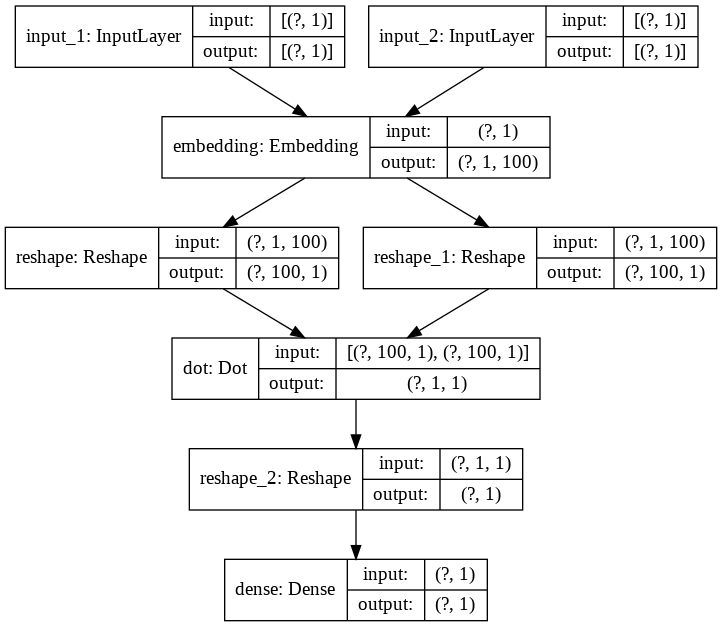

In [6]:
keras.utils.plot_model(model, show_shapes=True)

# index를 인풋으로 두개 받고,
# 그 인덱스를 embedding에 통과시킴으로서 one-hot * W를 곱한것과 같은 효과를 내주고
# W의 한줄이 곧 한 단어를 의미 --> 1차원 짜리 W를 dot을 통해 한줄만 추출

In [0]:
def generating_wordpairs(indexed_corpus, vocab_size, window_size=2):
  X = []
  Y = []
  for row in indexed_corpus:
    # row --> 각각의 문장에 대해서, i.e. "how are you"
    a = keras.preprocessing.sequence.skipgrams(sequence=row, vocabulary_size=vocab_size, window_size=window_size, negative_samples=1.0, shuffle=True, categorical=False, sampling_table=None, seed=None)
    print('skipgrams', a)
    x, y = a
    X = X + list(x)
    Y = Y + list(y)
  return X, Y

In [8]:

epochs = 1
batch_size = 3

for i in range(epochs):
    idx_batch = np.random.choice(len(indexed_corpus), batch_size)
    print('idx_batch', idx_batch)
    X, Y = generating_wordpairs(np.array(indexed_corpus)[idx_batch].tolist(), vocab_size)
    print('X:', X)
    print('Y:', Y)
    word_target, word_context = zip(*X)
    #print('word_target', word_target)
    #print('word_context', word_context)
    word_target = np.array(word_target, dtype=np.int32)
    word_context = np.array(word_context, dtype=np.int32)
    print('word_target', word_target)
    print('word_context', word_context)
    
    target = np.zeros((1,))
    context = np.zeros((1,))
    label = np.zeros((1,))
    idx = np.random.randint(0, len(Y)-1)
    target[0,] = word_target[idx]
    context[0,] = word_context[idx]
    label[0,] = Y[idx]
    print('idx', idx)
    print('target:', target)
    print('context:', context)
    print('label:', label)
    loss = model.train_on_batch([target, context], label)
    if i % 1 == 0:
        print("Iteration {}, loss={}".format(i, loss))

idx_batch [3 4 2]
skipgrams ([[2, 15], [2, 10], [1, 10], [1, 2], [1, 4], [1, 16], [10, 3], [2, 15], [10, 1], [10, 2], [10, 5], [2, 1]], [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1])
skipgrams ([[2, 6], [1, 15], [11, 12], [11, 12], [11, 12], [2, 8], [11, 3], [2, 11], [11, 2], [1, 12], [12, 11], [2, 12], [1, 11], [1, 5], [12, 11], [12, 1], [12, 13], [12, 1], [11, 1], [12, 2]], [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1])
skipgrams ([[7, 8], [9, 8], [9, 1], [7, 3], [7, 9], [8, 6], [7, 15], [8, 7], [9, 7], [9, 15], [8, 8], [8, 9]], [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1])
X: [[2, 15], [2, 10], [1, 10], [1, 2], [1, 4], [1, 16], [10, 3], [2, 15], [10, 1], [10, 2], [10, 5], [2, 1], [2, 6], [1, 15], [11, 12], [11, 12], [11, 12], [2, 8], [11, 3], [2, 11], [11, 2], [1, 12], [12, 11], [2, 12], [1, 11], [1, 5], [12, 11], [12, 1], [12, 13], [12, 1], [11, 1], [12, 2], [7, 8], [9, 8], [9, 1], [7, 3], [7, 9], [8, 6], [7, 15], [8, 7], [9, 7], [9, 15], [8, 8], [8, 9]]
Y: [0, 1, 1, 1, 0, 0, 0, 0, 1

### visualize

In [0]:
#X_target_new = np.array([5.])
#X_context_new = np.array([6.])

grad = model.get_weights()

In [10]:
grad[0].shape

(17, 100)

In [11]:
grad[0]

array([[ 0.01645621, -0.00589932, -0.01471175, ..., -0.04048269,
        -0.04138212,  0.01247839],
       [-0.01294935,  0.00139042,  0.01233207, ...,  0.0240727 ,
         0.01274442, -0.00268712],
       [ 0.03155038,  0.048104  ,  0.02928082, ..., -0.01852942,
         0.02591246, -0.04616255],
       ...,
       [ 0.01388434, -0.03151637,  0.00623218, ...,  0.03824879,
        -0.03567512, -0.00586488],
       [ 0.01017832,  0.03941515,  0.03742045, ..., -0.01840114,
         0.00694617, -0.04235482],
       [ 0.01438809,  0.04091888, -0.01207281, ..., -0.00702416,
         0.0337652 ,  0.04508159]], dtype=float32)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(grad[0])
PCA(n_components=2)
W_2 = pca.fit_transform(grad[0])

In [0]:
word_list = []
for i in range(len(word2index)):
  word_list.append(sorted(word2index.items(), key=lambda x: x[1])[i][0])

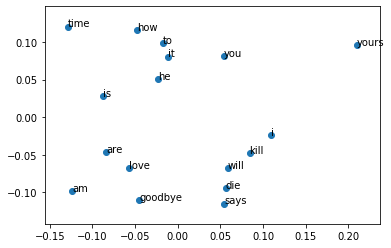

In [14]:
x = W_2[:,0]
y = W_2[:,1]
n = word_list

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

## Skipgram

In [0]:
indexed_corpus = tokenizer.texts_to_sequences(text)

embedding_dim = 100
vocab_size = len(word2index)

input_ = keras.layers.Input((1,))

embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim, input_length=1)
target_embedding = embedding_layer(input_)
target_layer = keras.layers.Reshape((1, embedding_dim))(target_embedding)
context_layer = keras.layers.Reshape((1, embedding_dim))(target_embedding)

target_output = keras.layers.Dense(1, activation='sigmoid')(target_layer)
context_output = keras.layers.Dense(1, activation='sigmoid')(context_layer)

model = keras.models.Model(inputs=[input_], outputs=[target_output, context_output])
#model.summary()
model.compile(loss='binary_crossentropy', optimizer='sgd')


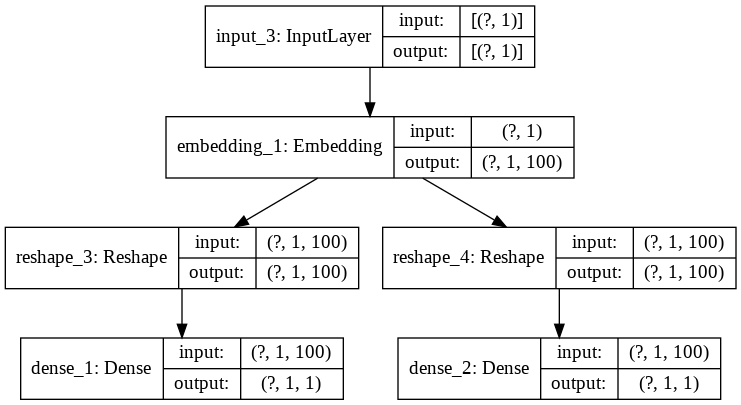

In [16]:
keras.utils.plot_model(model, show_shapes=True)

In [0]:
grad = model.get_weights()

In [18]:
grad[0].shape

(17, 100)

In [19]:
grad[0]

array([[ 0.02413679,  0.01285462, -0.04826153, ..., -0.03322836,
         0.01596291,  0.03011217],
       [-0.04667386,  0.00679704, -0.02052331, ...,  0.02656053,
         0.04200524, -0.00634357],
       [-0.00534525, -0.01481671, -0.04388114, ..., -0.00148666,
        -0.02894019, -0.02491723],
       ...,
       [-0.04253198, -0.03049729,  0.0458113 , ..., -0.01426946,
        -0.03683824, -0.02743478],
       [ 0.0170675 ,  0.03435068, -0.01595122, ..., -0.0286366 ,
        -0.03411828, -0.03717596],
       [-0.0058865 ,  0.0222169 ,  0.04638782, ..., -0.01716522,
        -0.00617989,  0.04208746]], dtype=float32)